In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to the dataset
root = '../lenses'
dataset = datasets.ImageFolder(root=root, transform=transform)

# Split the dataset with ratio train: 80, val: 10, test: 10
train_size = int(0.8 * len(dataset))
test_size = int(len(dataset) - train_size)
val_size = int(0.5 * test_size)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
val_dataset, test_dataset = random_split(test_dataset, [val_size, val_size])

# Set the batch size
batch_size = 50

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print some information
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 8048
Val dataset size: 1006
Test dataset size: 1006
Image shape: torch.Size([3, 150, 150])
Classes: ['no_sub', 'sub']
Image tensor type: torch.float32
Batches: 161


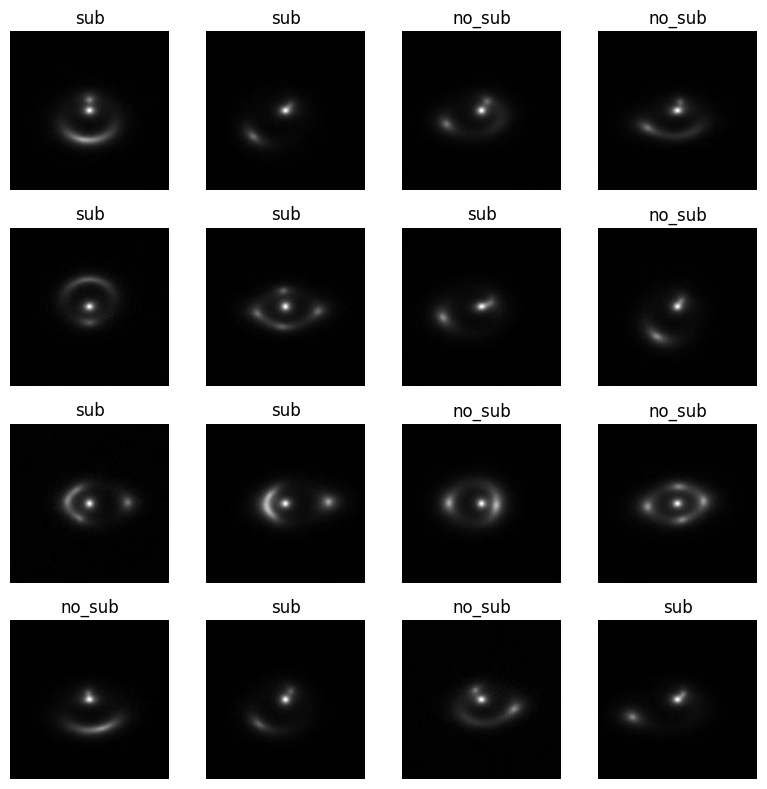

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [43]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, warmup_epochs=None, save_path='../best_param_CvT.pt'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    } # Initialize a dictionary to store epoch-wise results
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Warm-up period
        if warmup_epochs is not None:
            if epoch < warmup_epochs:
                scheduler = None
                lr = 1e-13 * (10 ** epoch)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(F.softmax(outputs, dim=1), 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(F.softmax(outputs, dim=1), 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Epoch [{epoch + 1}/{num_epochs}] w/ LR = {optimizer.param_groups[0]['lr']}")
        print(f"\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}")
        print(f"\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}")

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        model.load_state_dict(torch.load(save_path))

    return history, model

In [37]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    y_pred = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(F.softmax(outputs, dim=1), 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred.extend(F.softmax(outputs, dim=1).cpu().numpy())
            y_pred_probs.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # # Binarize the labels for ROC AUC
    # y_true_binary = label_binarize(y_true, classes=[0, 1])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no_sub', 'sub']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred_probs)
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, np.array(y_pred)[:, 1])
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [28]:
from transformers import CvtForImageClassification, CvtConfig

config = CvtConfig(
    depth=[1, 2, 10],
    embed_dim=[64, 192, 384],
    id2label={0: 'no_sub', 1: 'sub'},
    image_size=150,
    label2id={'no_sub': 0, 'sub': 1},
    num_channels=3,
    num_heads=[1, 3, 6],
    num_labels=2
)
model = CvtForImageClassification(config)
model.to(device)

print(model.config)
model

CvtConfig {
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    10
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    64,
    192,
    384
  ],
  "id2label": {
    "0": "no_sub",
    "1": "sub"
  },
  "image_size": 150,
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "label2id": {
    "no_sub": 0,
    "sub": 1
  },
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 3,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
    "dw_bn",
    "dw_bn",
    "

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# Load checkpoint
model.load_state_dict(torch.load('../best_param_CvT.pt'))

In [44]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

history, model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print('Finished')

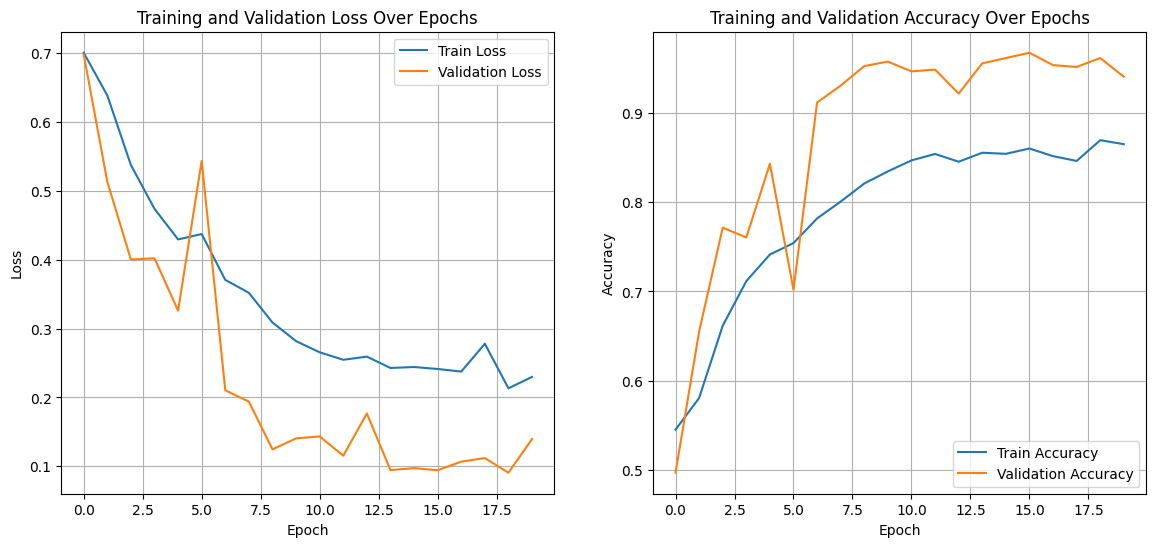

In [32]:
plt.figure(figsize=(14, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

Test Loss: 0.1053
Accuracy: 0.9592
ROC AUC: 0.9595


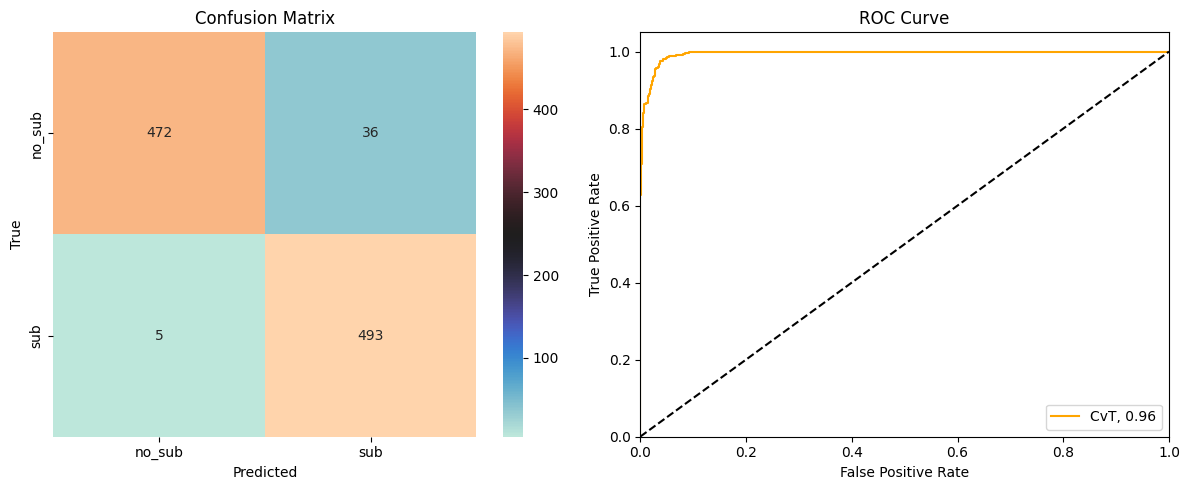

In [38]:
evaluate_model(model, criterion, 'CvT')